In [47]:
# 09_anomaly_features.ipynb

import pandas as pd
import numpy as np
from pathlib import Path
import logging
from src.data_tools.czech_data_tools import load_czech_media_data

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Load the data
def load_data():
    """
    Load and prepare the data for anomaly detection
    """
    # Load comments from the media source
    logger.info("Loading comments from media source...")
    comments_df = load_czech_media_data()
    
    # Basic data cleaning
    comments_df = comments_df.dropna(subset=['text', 'author'])
    
    # Convert timestamp to datetime if it isn't already
    comments_df['timestamp'] = pd.to_datetime(comments_df['timestamp'])
    
    # Sort by timestamp
    comments_df = comments_df.sort_values('timestamp')
    
    logger.info(f"Loaded {len(comments_df)} comments from {len(comments_df['author'].unique())} unique authors")
    
    return comments_df

# Load the data
comments_df = load_data()

INFO:__main__:Loading comments from media source...
Loading files: 100%|██████████████████████████████████████████████████████████████████| 124/124 [00:14<00:00,  8.65it/s]
INFO:__main__:Loaded 845764 comments from 66590 unique authors


In [48]:
# Display basic information about the dataset
print("\nDataset Overview:")
print("-" * 50)
print(f"Total number of comments: {len(comments_df)}")
print(f"Total number of unique authors: {len(comments_df['author'].unique())}")
print(f"Date range: {comments_df['timestamp'].min()} to {comments_df['timestamp'].max()}")
print("\nColumns in the dataset:")
for col in comments_df.columns:
    print(f"- {col}")


Dataset Overview:
--------------------------------------------------
Total number of comments: 845764
Total number of unique authors: 66590
Date range: 2024-11-01 00:00:00 to 2025-03-04 15:31:00

Columns in the dataset:
- text
- raw_text
- author
- timestamp
- article_title
- url
- article_id
- sentiment


In [53]:
# First, let's create a subset of the data
def create_data_subset(df, n_users=100, min_comments=5):
    """
    Create a subset of the data for faster testing
    
    Args:
        df: Original dataframe
        n_users: Number of users to include
        min_comments: Minimum number of comments per user
    """
    # Get users with minimum number of comments
    user_counts = df['author'].value_counts()
    eligible_users = user_counts[user_counts >= min_comments].index
    
    # Select random subset of eligible users
    selected_users = np.random.choice(eligible_users, min(n_users, len(eligible_users)), replace=False)
    
    # Get all comments from selected users
    subset_df = df[df['author'].isin(selected_users)].copy()
    
    print(f"Created subset with {len(subset_df)} comments from {len(selected_users)} users")
    return subset_df

In [ ]:
def create_time_features(df):
    """
    Create time-based features for each user
    """
    time_features = []
    
    for author in df['author'].unique():
        user_comments = df[df['author'] == author]
        
        # Calculate time difference in days
        time_diff = (user_comments['timestamp'].max() - user_comments['timestamp'].min()).total_seconds() / (24 * 3600)
        
        # If all comments are on the same day, use 1 day as the denominator
        time_diff = max(1, time_diff)
        
        features = {
            'author': author,
            'total_comments': len(user_comments),
            'avg_comments_per_day': len(user_comments) / time_diff,
            'hour_variance': user_comments['timestamp'].dt.hour.var(),
            'weekend_ratio': len(user_comments[user_comments['timestamp'].dt.dayofweek.isin([5,6])]) / len(user_comments),
            'night_ratio': len(user_comments[user_comments['timestamp'].dt.hour.isin([23,0,1,2,3,4,5])]) / len(user_comments),
            'time_span_days': time_diff,
            'unique_days': user_comments['timestamp'].dt.date.nunique(),
            'comments_per_unique_day': len(user_comments) / user_comments['timestamp'].dt.date.nunique()
        }
        
        # Add hour distribution features
        hour_dist = user_comments['timestamp'].dt.hour.value_counts(normalize=True)
        for hour in range(24):
            features[f'hour_{hour:02d}_ratio'] = hour_dist.get(hour, 0)
        
        time_features.append(features)
    
    return pd.DataFrame(time_features)




Created subset with 29243 comments from 1000 users


In [98]:
# Create subset
np.random.seed(42)  # for reproducibility
comments_subset = create_data_subset(comments_df, n_users=10, min_comments=5)

Created subset with 131 comments from 10 users


In [59]:
# Try with the subset
time_features_df = create_time_features(comments_subset)

# Display results
print("\nExample of time-based features:")
print(time_features_df.head())

# Show basic statistics for main features
main_features = ['total_comments', 'avg_comments_per_day', 'hour_variance', 
                 'weekend_ratio', 'night_ratio', 'time_span_days', 
                 'unique_days', 'comments_per_unique_day']

print("\nFeature Statistics:")
print(time_features_df[main_features].describe())


Example of time-based features:
               author  total_comments  avg_comments_per_day  hour_variance  \
0        Milan Krejsa              35              0.287425      44.137815   
1      Zdenek Sobotka              33              0.267839      47.445076   
2      Maxmilian Kelt              79              0.645597      52.754625   
3        Ondrej Zeman              64              3.652071      22.968254   
4  Gardavsky Miroslav              32              0.260819      29.544355   

   weekend_ratio  night_ratio  time_span_days  unique_days  \
0       0.200000     0.200000      121.770833           25   
1       0.363636     0.272727      123.208333           18   
2       0.202532     0.367089      122.367361           39   
3       0.328125     0.062500       17.524306           15   
4       0.375000     0.093750      122.690278           24   

   comments_per_unique_day  hour_00_ratio  hour_01_ratio  hour_02_ratio  \
0                 1.400000       0.085714       0.

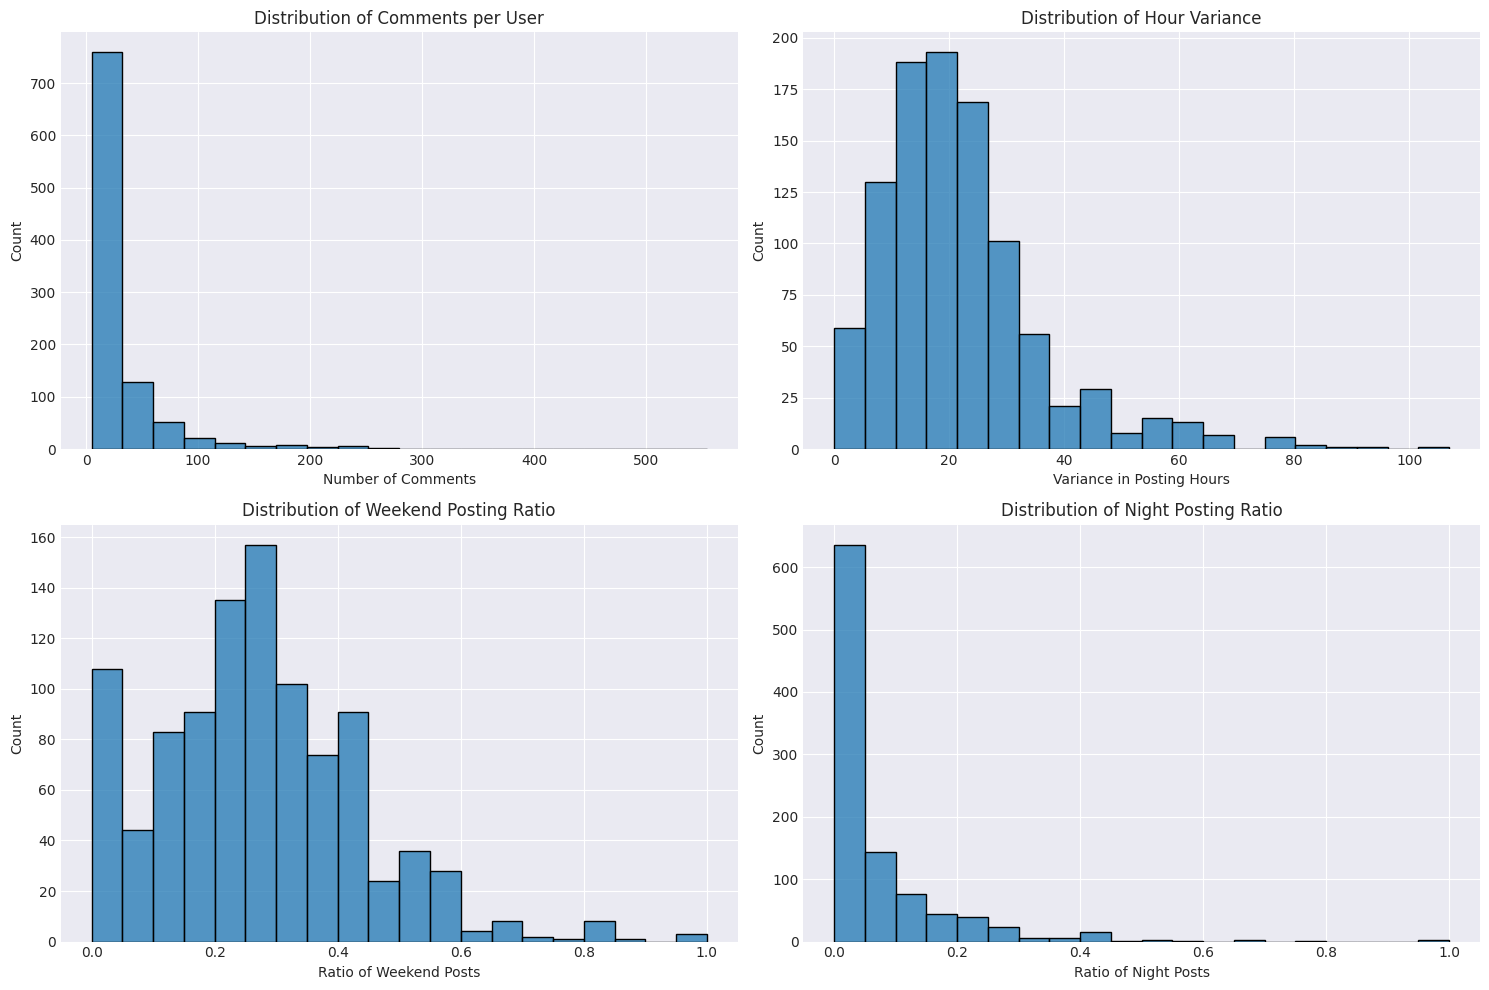

In [60]:
# Visualize some key distributions
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

# Plot 1: Comments per user
plt.subplot(2, 2, 1)
sns.histplot(time_features_df['total_comments'], bins=20)
plt.title('Distribution of Comments per User')
plt.xlabel('Number of Comments')

# Plot 2: Hour variance
plt.subplot(2, 2, 2)
sns.histplot(time_features_df['hour_variance'], bins=20)
plt.title('Distribution of Hour Variance')
plt.xlabel('Variance in Posting Hours')

# Plot 3: Weekend ratio
plt.subplot(2, 2, 3)
sns.histplot(time_features_df['weekend_ratio'], bins=20)
plt.title('Distribution of Weekend Posting Ratio')
plt.xlabel('Ratio of Weekend Posts')

# Plot 4: Night ratio
plt.subplot(2, 2, 4)
sns.histplot(time_features_df['night_ratio'], bins=20)
plt.title('Distribution of Night Posting Ratio')
plt.xlabel('Ratio of Night Posts')

plt.tight_layout()
plt.show()

In [61]:
import re
from collections import Counter
from typing import List, Dict
import string
from sklearn.feature_extraction.text import CountVectorizer

def preprocess_text(text: str) -> str:
    """
    Preprocess text for feature extraction
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis and special characters
    text = re.sub(r'[^\w\s,.!?-]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

def create_text_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create text-based features for each user
    
    Features include:
    - Average comment length (chars and words)
    - Vocabulary diversity
    - Punctuation usage
    - Special patterns (ALL CAPS, repeated chars)
    - Most common words
    """
    text_features = []
    
    for author in df['author'].unique():
        user_comments = df[df['author'] == author]
        
        # Get raw and preprocessed texts
        raw_texts = user_comments['text'].tolist()
        processed_texts = [preprocess_text(text) for text in raw_texts]
        
        # Basic length features
        avg_char_length = np.mean([len(text) for text in raw_texts])
        avg_word_length = np.mean([len(text.split()) for text in processed_texts])
        
        # Vocabulary features
        all_words = [word for text in processed_texts for word in text.split()]
        unique_words = set(all_words)
        vocabulary_size = len(unique_words)
        vocabulary_diversity = vocabulary_size / len(all_words) if all_words else 0
        
        # Punctuation features
        punctuation_counts = {
            'exclamation': sum(text.count('!') for text in raw_texts) / len(raw_texts),
            'question': sum(text.count('?') for text in raw_texts) / len(raw_texts),
            'dots': sum(text.count('...') for text in raw_texts) / len(raw_texts),
        }
        
        # Special patterns
        caps_ratio = sum(sum(1 for c in text if c.isupper()) / len(text) if len(text) > 0 else 0 
                        for text in raw_texts) / len(raw_texts)
        
        # Repeated characters (e.g., "!!!", "???")
        repeated_chars = sum(len(re.findall(r'(.)\1{2,}', text)) for text in raw_texts) / len(raw_texts)
        
        # Create feature dictionary
        features = {
            'author': author,
            'avg_chars_per_comment': avg_char_length,
            'avg_words_per_comment': avg_word_length,
            'vocabulary_size': vocabulary_size,
            'vocabulary_diversity': vocabulary_diversity,
            'exclamation_ratio': punctuation_counts['exclamation'],
            'question_ratio': punctuation_counts['question'],
            'dots_ratio': punctuation_counts['dots'],
            'caps_ratio': caps_ratio,
            'repeated_chars_ratio': repeated_chars
        }
        
        # Add most common words (top 5)
        word_counts = Counter(all_words)
        for i, (word, count) in enumerate(word_counts.most_common(5)):
            features[f'common_word_{i+1}'] = word
            features[f'common_word_{i+1}_freq'] = count / len(all_words)
        
        text_features.append(features)
    
    return pd.DataFrame(text_features)

In [62]:
text_features_df = create_text_features(comments_subset)

# Display results
print("\nExample of text-based features:")
print(text_features_df.head())

# Show basic statistics
print("\nFeature Statistics:")
numeric_columns = text_features_df.select_dtypes(include=[np.number]).columns
print(text_features_df[numeric_columns].describe())



Example of text-based features:
               author  avg_chars_per_comment  avg_words_per_comment  \
0        Milan Krejsa              97.714286              16.400000   
1      Zdenek Sobotka             206.454545              34.060606   
2      Maxmilian Kelt             216.924051              34.253165   
3        Ondrej Zeman             113.093750              19.187500   
4  Gardavsky Miroslav              96.281250              15.875000   

   vocabulary_size  vocabulary_diversity  exclamation_ratio  question_ratio  \
0              405              0.705575           0.000000        0.171429   
1              687              0.611210           0.424242        0.060606   
2             1378              0.509239           0.177215        0.670886   
3              721              0.587134           0.000000        0.453125   
4              354              0.696850           0.218750        0.218750   

   dots_ratio  caps_ratio  repeated_chars_ratio common_word_1  \


In [103]:
from transformers import AutoTokenizer
import string
import sys
from pathlib import Path

# Get the current notebook's directory
current_dir = Path("/home/luuka/thesis/workspace/notebooks")

# Import stopwords downloaded from SpaCy
with open(current_dir / "stop_words.py", "r", encoding="utf-8") as f:
    exec(f.read())  

# Load the Czech RobeCzech tokenizer
tokenizer = AutoTokenizer.from_pretrained("ufal/robeczech-base")

def enhanced_preprocess_czech_text(text: str) -> List[str]:
    """
    Preprocess Czech text using RobeCzech tokenizer
    Preserves Czech diacritics while removing special characters
    """
    # Tokenize using RobeCzech
    tokens = tokenizer.tokenize(text)
    
    # Only remove the Ġ prefix (tokenizer artifact)
    tokens = [token.replace('Ġ', '') for token in tokens]
    
    # Remove special characters and punctuation
    tokens = [token for token in tokens 
             if not (token in string.punctuation 
                    or token.startswith('##')
                    or token.startswith('['))]
    
    # Remove stopwords
    tokens = [token for token in tokens if token.lower() not in STOP_WORDS]
    
    return tokens

# Test on example text
example_text = "Prezident Petr Pavel navštívil včera Prahu a setkal se s ministry vlády."
print("\nExample tokenization:")
print("Original:", example_text)
print("Tokenized:", enhanced_preprocess_czech_text(example_text))



Example tokenization:
Original: Prezident Petr Pavel navštívil včera Prahu a setkal se s ministry vlády.
Tokenized: ['Prezident', 'Petr', 'Pavel', 'navÅ¡tÃŃvil', 'vÄįera', 'Prahu', 'setkal', 'ministry', 'vlÃ¡dy']


In [88]:
# Test on a variety of Czech texts
test_texts = [
    "Prezident Petr Pavel navštívil včera Prahu a setkal se s ministry vlády.",
    "Žluťoučký kůň úpěl ďábelské ódy.",
    "Příliš žluťoučký kůň úpěl ďábelské ódy."
]

print("\nTesting with various Czech texts:")
for text in test_texts:
    print("\nOriginal:", text)
    print("Tokenized:", enhanced_preprocess_czech_text(text))

# Let's also examine the actual bytes to understand the encoding
print("\nDetailed token analysis for first text:")
tokens = tokenizer.tokenize(test_texts[0])
for token in tokens:
    print(f"\nToken: {token}")
    print(f"Bytes: {token.encode('utf-8')}")
    print(f"Without Ġ: {token.replace('Ġ', '')}")


Testing with various Czech texts:

Original: Prezident Petr Pavel navštívil včera Prahu a setkal se s ministry vlády.
Tokenized: ['Prezident', 'Petr', 'Pavel', 'navÅ¡tÃŃvil', 'vÄįera', 'Prahu', 'setkal', 'ministry', 'vlÃ¡dy']

Original: Žluťoučký kůň úpěl ďábelské ódy.
Tokenized: ['Å½lu', 'Å¥', 'ou', 'ÄįkÃ½', 'kÅ¯ÅĪ', 'Ãº', 'pÄĽl', 'ÄıÃ¡bel', 'skÃ©', 'Ã³', 'dy']

Original: Příliš žluťoučký kůň úpěl ďábelské ódy.
Tokenized: ['PÅĻÃŃliÅ¡', 'Å¾lu', 'Å¥', 'ou', 'ÄįkÃ½', 'kÅ¯ÅĪ', 'Ãº', 'pÄĽl', 'ÄıÃ¡bel', 'skÃ©', 'Ã³', 'dy']

Detailed token analysis for first text:

Token: Prezident
Bytes: b'Prezident'
Without Ġ: Prezident

Token: ĠPetr
Bytes: b'\xc4\xa0Petr'
Without Ġ: Petr

Token: ĠPavel
Bytes: b'\xc4\xa0Pavel'
Without Ġ: Pavel

Token: ĠnavÅ¡tÃŃvil
Bytes: b'\xc4\xa0nav\xc3\x85\xc2\xa1t\xc3\x83\xc5\x83vil'
Without Ġ: navÅ¡tÃŃvil

Token: ĠvÄįera
Bytes: b'\xc4\xa0v\xc3\x84\xc4\xafera'
Without Ġ: vÄįera

Token: ĠPrahu
Bytes: b'\xc4\xa0Prahu'
Without Ġ: Prahu

Token: Ġa
Bytes: b'\xc4\xa0a'
With


Text features shape: (1000, 30)

Feature columns: ['author', 'total_comments', 'total_tokens', 'unique_tokens', 'avg_tokens_per_comment', 'vocabulary_diversity', 'avg_chars_per_comment', 'std_chars_per_comment', 'max_comment_length', 'min_comment_length', 'exclamation_ratio', 'question_ratio', 'dots_ratio', 'caps_ratio', 'repeated_chars_ratio', 'common_token_1', 'common_token_1_freq', 'common_token_2', 'common_token_2_freq', 'common_token_3', 'common_token_3_freq', 'common_token_4', 'common_token_4_freq', 'common_token_5', 'common_token_5_freq', 'avg_token_length', 'std_token_length', 'max_token_length', 'std_tokens_per_comment', 'max_tokens_per_comment']

Numeric feature statistics:
       total_comments  total_tokens  unique_tokens  avg_tokens_per_comment  \
count     1000.000000   1000.000000    1000.000000             1000.000000   
mean        29.243000    948.576000     542.653000               31.945285   
std         45.620601   1957.913668     724.103761               20.7866

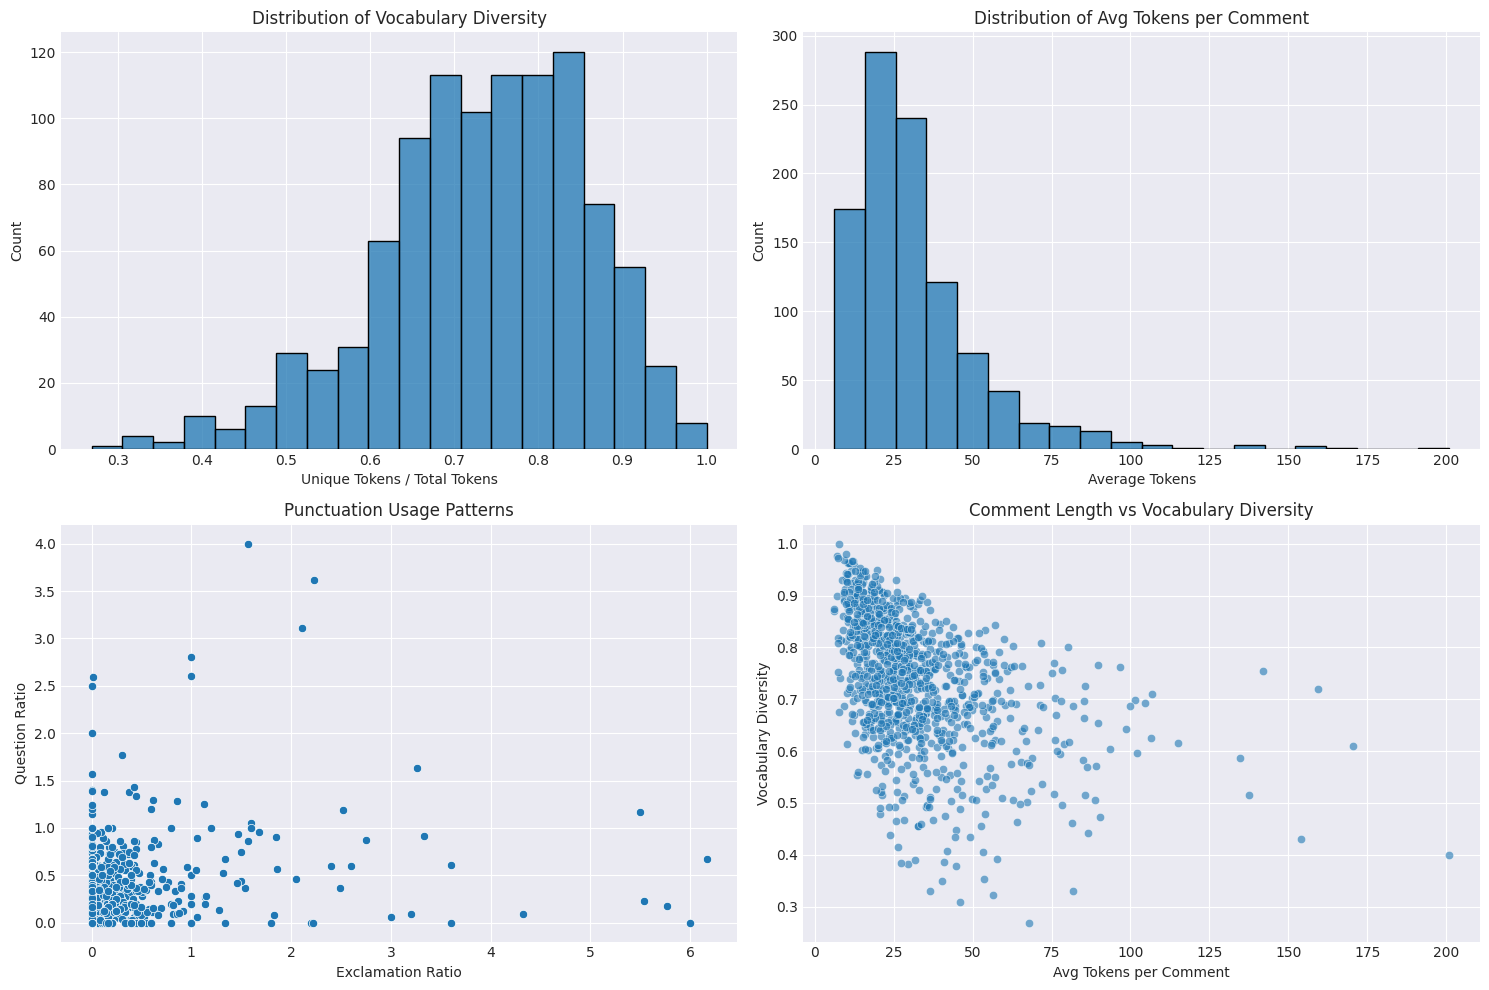


Users with highest vocabulary diversity:
                author  vocabulary_diversity  total_comments
638     Karel Zaorálek              1.000000               5
965  Vlastimil Hovorka              0.980000               5
603       Petr Vaněček              0.976190               6
976        Petr Sváček              0.972973               5
911         Mill Zeman              0.968750               7

Users with most repetitive vocabulary:
                 author  vocabulary_diversity  total_comments
18     Miroslav Šilhavý              0.268873             554
192          Jan Švejda              0.309626             121
197          Tomáš Tasz              0.322859             238
299        Lukáš Klazar              0.329063             262
50   František Janoušek              0.330224             246

Users with most extreme punctuation usage:
               author  exclamation_ratio  question_ratio  total_comments
894     Beda Schäffer           6.166667        0.666667       

In [85]:
def create_text_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create text-based features for each user using our enhanced tokenization
    """
    text_features = []
    
    for author in df['author'].unique():
        user_comments = df[df['author'] == author]
        raw_texts = user_comments['text'].tolist()
        
        # Get tokenized version of all comments
        tokenized_comments = [enhanced_preprocess_czech_text(text) for text in raw_texts]
        
        # All tokens for this user
        all_tokens = [token for comment in tokenized_comments for token in comment]
        
        # Basic count features
        features = {
            'author': author,
            'total_comments': len(raw_texts),
            'total_tokens': len(all_tokens),
            'unique_tokens': len(set(all_tokens)),
            'avg_tokens_per_comment': len(all_tokens) / len(raw_texts) if raw_texts else 0,
            'vocabulary_diversity': len(set(all_tokens)) / len(all_tokens) if all_tokens else 0,
        }
        
        # Raw text features (before tokenization)
        features.update({
            'avg_chars_per_comment': np.mean([len(text) for text in raw_texts]),
            'std_chars_per_comment': np.std([len(text) for text in raw_texts]),
            'max_comment_length': max(len(text) for text in raw_texts),
            'min_comment_length': min(len(text) for text in raw_texts),
        })
        
        # Punctuation and special character features
        features.update({
            'exclamation_ratio': sum(text.count('!') for text in raw_texts) / len(raw_texts),
            'question_ratio': sum(text.count('?') for text in raw_texts) / len(raw_texts),
            'dots_ratio': sum(text.count('...') for text in raw_texts) / len(raw_texts),
            'caps_ratio': sum(sum(1 for c in text if c.isupper()) / len(text) if len(text) > 0 else 0 
                            for text in raw_texts) / len(raw_texts),
            'repeated_chars_ratio': sum(len(re.findall(r'(.)\1{2,}', text)) 
                                     for text in raw_texts) / len(raw_texts),
        })
        
        # Token distribution features
        token_counts = Counter(all_tokens)
        
        # Most common tokens and their frequencies
        for i, (token, count) in enumerate(token_counts.most_common(5)):
            features[f'common_token_{i+1}'] = token
            features[f'common_token_{i+1}_freq'] = count / len(all_tokens)
        
        # Token length features
        token_lengths = [len(token) for token in all_tokens]
        features.update({
            'avg_token_length': np.mean(token_lengths) if token_lengths else 0,
            'std_token_length': np.std(token_lengths) if token_lengths else 0,
            'max_token_length': max(token_lengths) if token_lengths else 0,
        })
        
        # Comment complexity features
        features.update({
            'avg_tokens_per_comment': np.mean([len(tokens) for tokens in tokenized_comments]),
            'std_tokens_per_comment': np.std([len(tokens) for tokens in tokenized_comments]),
            'max_tokens_per_comment': max(len(tokens) for tokens in tokenized_comments),
        })
        
        text_features.append(features)
    
    return pd.DataFrame(text_features)

# Run on our subset
text_features_df = create_text_features(comments_subset)

# Display results
print("\nText features shape:", text_features_df.shape)
print("\nFeature columns:", text_features_df.columns.tolist())

# Show basic statistics for numeric features
numeric_features = text_features_df.select_dtypes(include=[np.number]).columns
print("\nNumeric feature statistics:")
print(text_features_df[numeric_features].describe())

# Visualize key distributions
plt.figure(figsize=(15, 10))

# Plot 1: Vocabulary diversity
plt.subplot(2, 2, 1)
sns.histplot(text_features_df['vocabulary_diversity'], bins=20)
plt.title('Distribution of Vocabulary Diversity')
plt.xlabel('Unique Tokens / Total Tokens')

# Plot 2: Average tokens per comment
plt.subplot(2, 2, 2)
sns.histplot(text_features_df['avg_tokens_per_comment'], bins=20)
plt.title('Distribution of Avg Tokens per Comment')
plt.xlabel('Average Tokens')

# Plot 3: Punctuation usage
plt.subplot(2, 2, 3)
sns.scatterplot(data=text_features_df, x='exclamation_ratio', y='question_ratio')
plt.title('Punctuation Usage Patterns')
plt.xlabel('Exclamation Ratio')
plt.ylabel('Question Ratio')

# Plot 4: Comment length vs vocabulary diversity
plt.subplot(2, 2, 4)
sns.scatterplot(data=text_features_df, 
                x='avg_tokens_per_comment', 
                y='vocabulary_diversity',
                alpha=0.6)
plt.title('Comment Length vs Vocabulary Diversity')
plt.xlabel('Avg Tokens per Comment')
plt.ylabel('Vocabulary Diversity')

plt.tight_layout()
plt.show()

# Show examples of users with extreme values
print("\nUsers with highest vocabulary diversity:")
print(text_features_df.nlargest(5, 'vocabulary_diversity')[['author', 'vocabulary_diversity', 'total_comments']])

print("\nUsers with most repetitive vocabulary:")
print(text_features_df.nsmallest(5, 'vocabulary_diversity')[['author', 'vocabulary_diversity', 'total_comments']])

print("\nUsers with most extreme punctuation usage:")
text_features_df['punctuation_score'] = text_features_df['exclamation_ratio'] + text_features_df['question_ratio']
print(text_features_df.nlargest(5, 'punctuation_score')[['author', 'exclamation_ratio', 'question_ratio', 'total_comments']])